1. $$\min_G \max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right],$$

$$\max_G  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:

$$\max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


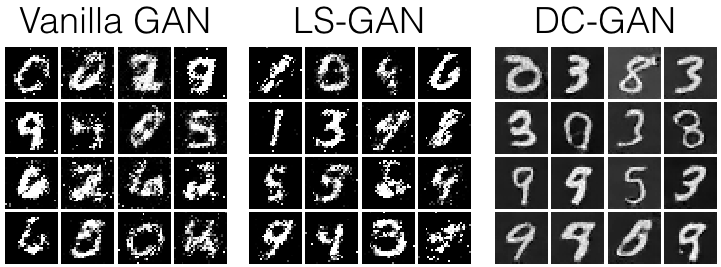

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A4 folder, then 'STA9131/A4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'STA9131/A4'

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['ICTR.ipynb', 'ICTR.py', '__pycache__', 'common', 'cvae.jpg', 'dcgan.jpg', 'fcgan.jpg', 'gan.ipynb', 'gan.py', 'lsgan.jpg', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.pt', 'pytorch_autograd_and_nn.py', 'suyeong_kim-2022324003-A4-O1.zip', 'vae.ipynb', 'vae.jpg', 'vae.py']


In [4]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from gan import hello as hello_gan
hello_gan()

gan_path = os.path.join(GOOGLE_DRIVE_PATH, "gan.py")
gan_edit_time = time.ctime(os.path.getmtime(gan_path))
print("gan.py last edited on %s" % gan_edit_time)

Hello from common!
Hello from gan.py!
gan.py last edited on Fri Aug 25 15:27:44 2023


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import common
from common import reset_seed
from common.helpers import count_params, show_images
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)  # (6.0, 4.0)
plt.rcParams['font.size'] = 16  # 10.0
plt.rcParams['image.interpolation'] = 'nearest'  # 'antialiased'
plt.rcParams['image.cmap'] = 'gray'  # viridis

## Device Setting

We will use `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.
Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype) for more details about data types.

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [6]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = torch.device('cuda')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = torch.device('cpu')

print('Default torch.dtype is:', torch.get_default_dtype())

Good to go! You are using Tesla T4
Default torch.dtype is: torch.float32


## Load MNIST

GANs are notoriously finicky with hyperparameters, and also require many training epochs.
In order to make this notebook approachable, we will be working on the MNIST dataset of 28x28 grayscale images, which has 60k training and 10k test images.
Each image contains a centered image of white digit from 0 to 9 on black background.
This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

We load the MNIST dataset using [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).
Run the following cell to get the data loader.

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

path = './data'
batch_size = 128

# pixel value range [-1, 1]
transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
transform = transforms.Compose(transform_list)

train_dataset = datasets.MNIST(path, train=True, download=True,
                               transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 131680801.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11228744.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47187157.72it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16638016.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



It is always a good idea to look at examples from the dataset before working with it.
We provide the function `show_images` to visualize the images.
Run the following cell to visualize some images in the dataset.


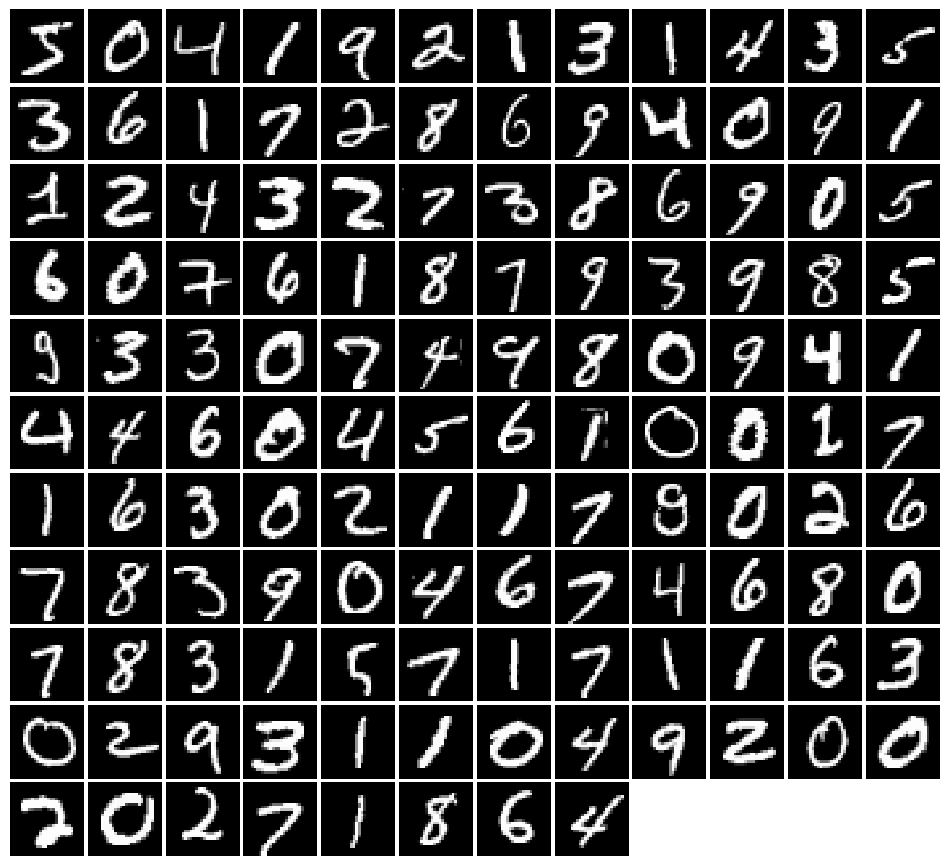

In [8]:
reset_seed(0)

imgs = train_dataset.data[:batch_size]
show_images(imgs)

# Random Noise
The first step is to generate uniform noise ranging from -1 to 1 with shape `(batch_size, noise_size)`.

**Implement** `sample_noise` and verify all tests pass below.

In [9]:
from gan import sample_noise

torch.manual_seed(0)

batch_size = 3
noise_size = 4

z = sample_noise(batch_size, noise_size)
assert z.shape == (batch_size, noise_size)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


## Discriminator

To implement a fully-connected GAN model, we will start with the discriminator, which takes a batch of images as input and pass them through two Linear + LeakyReLU layers mapping to the hidden space and the last Linear layer mapping to the score of being real images.

Let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_discriminator` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size `D` and output size `H`
2. Leaky ReLU with `alpha=0.01`
3. Fully-connected layer with input_size `H` and output size `H`
4. Leaky ReLU with `alpha=0.01`
5. Fully-connected layer with input size `H` and output size `1`

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; we use $\alpha = 0.01$ for this discriminator.

The output of the discriminator should have shape `(batch_size, 1)`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Note that you don't have to flatten the input here, as it will be done in the training script.

In [10]:
from gan import get_discriminator

model = get_discriminator(784, 256)
cur_count = count_params(model)
if cur_count != 267009:
    print('**Incorrect** number of parameters in discriminator: ', cur_count)
else:
    print('**Correct** number of parameters in discriminator:', cur_count)

**Correct** number of parameters in discriminator: 267009


## Generator

We now define the generator, which takes noise and generate images.

Again, let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_generator` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size as the latent size `Z` and output size `H`
2. ReLU
3. Fully-connected layer with input size `H` and output size `H`
4. ReLU
5. Fully-connected layer with input size `H` and output size `D`
6. Hyperbolic tangent (Tanh)

Here, we apply Tanh to clip the image to be in the range of `[-1, 1]`.

Note that you don't have to unflatten the output, it will be done in the training script whenever necessary.

In [11]:
from gan import get_generator

model = get_generator(4, 256, 784)
cur_count = count_params(model)
if cur_count != 268560:
    print('**Incorrect** number of parameters in generator: ', cur_count)
else:
    print('**Correct** number of parameters in generator:', cur_count)

**Correct** number of parameters in generator: 268560


## GAN Loss

Compute the discriminator and generator loss separately.
The discriminator loss is

$$\ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right],$$

and to avoid vanishing gradients at the beginning, we use the modified generator loss:

$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right].$$

Note that these are negated from the equations presented earlier as we will *minimize* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 \leq D(x) \leq 1$ which results from squashing the raw score from the discriminator through a sigmoid function.
However, for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above; instead, we will implement the sigmoid as part of the loss function, i.e., the binary cross-entropy loss with logits.
(For more details about the binary cross-entropy loss, you might check the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html).)

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross-entropy loss (with logits) is defined as:

$$ \text{BCE}(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.
A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. For example:

`true_labels = torch.ones(size)`

`fake_labels = torch.zeros(size)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the batch, so make sure to combine the loss by averaging instead of summing.

**Implement** `discriminator_loss` and `generator_loss` and verify your implementation below.
Your relative error should be very small.

## Training FC-GAN

Now that we have our GAN defined and loss functions ready, let's train our model!
A training script is provided below.
You don't have to additionally implement anything, so just run the cells below.

In [12]:
def train_gan(train_loader, D, G, D_solver, G_solver, discriminator_loss,
              generator_loss, noise_size, epochs=10, savefig=None, step_size=1):


    D = D.to(device)
    G = G.to(device)

    prev_time = time.time()
    for epoch in range(epochs):
        k=1
        for x, _ in train_loader:
            # update D
            D_solver.zero_grad()
            x = x.view(x.shape[0], -1).to(dtype=torch.float, device=device)
            logits_real = D(x)

            g_fake_seed = sample_noise(x.shape[0], noise_size).to(x)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images)

            d_error = discriminator_loss(logits_real, logits_fake)
            d_error.backward()
            D_solver.step()

            if k % step_size == 0:
              # update G
              G_solver.zero_grad()
              g_fake_seed = sample_noise(x.shape[0], noise_size).to(x)
              fake_images = G(g_fake_seed)

              gen_logits_fake = D(fake_images)
              g_error = generator_loss(gen_logits_fake)
              g_error.backward()
              G_solver.step()
              k += 1
            else:
              k += 1

        fmt = 'Train Time: {:6.2f} Epoch: {:3d} D: {:6.4f} G: {:6.4f}'
        print(fmt.format(time.time() - prev_time, epoch,
                         d_error.item(), g_error.item()))

        imgs_numpy = fake_images.data.cpu().numpy()
        if savefig and epoch == epochs-1:
            path = os.path.join(GOOGLE_DRIVE_PATH, savefig)
        else:
            path = None
        show_images(imgs_numpy[:16], savefig=path)
        plt.show()
        print()

Now, run the cell below to train your GAN!
We have pre-defined Adam optimizers, learning rate, and the number of epochs for you to use.

You should start to see decent shapes, about half of which will be recognizable digits around epoch 4.
You might still see some artifacts at the end of training, but that's fine.
Training a good GAN is known to be notoriously hard, taking a longer and sophisticated training.

Training for 10 epochs should take around **8 mins** on CPU, or **3 mins** on Tesla T4 GPU.
Your last epoch results will be stored in `fcgan.jpg`.

Train Time:  13.42 Epoch:   0 D: 0.7491 G: 1.8551


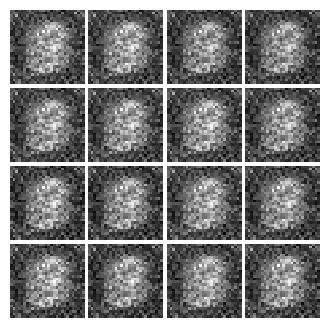


Train Time:  27.17 Epoch:   1 D: 0.2900 G: 2.9692


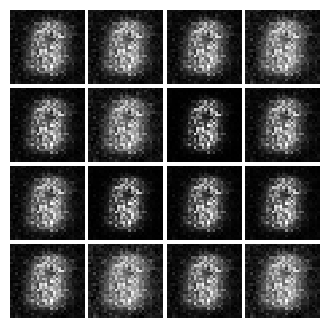


Train Time:  40.68 Epoch:   2 D: 0.2659 G: 2.6688


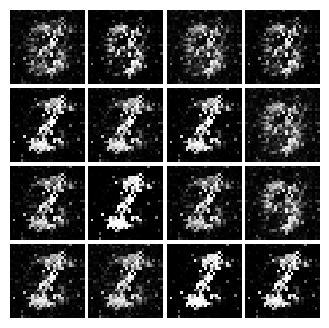


Train Time:  54.33 Epoch:   3 D: 0.7523 G: 2.4696


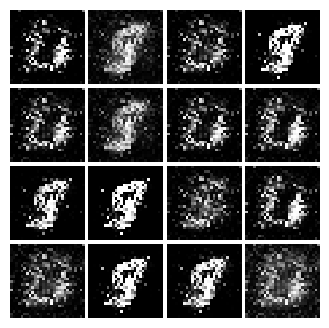


Train Time:  68.39 Epoch:   4 D: 0.1339 G: 3.5438


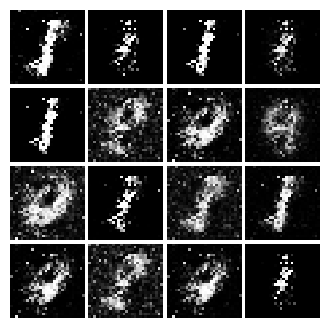


Train Time:  81.95 Epoch:   5 D: 0.3737 G: 4.2557


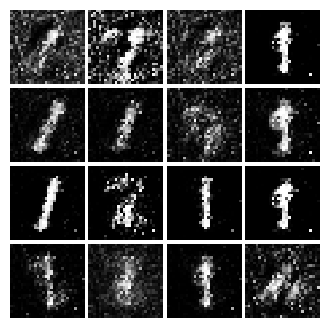


Train Time:  95.75 Epoch:   6 D: 0.4681 G: 2.4180


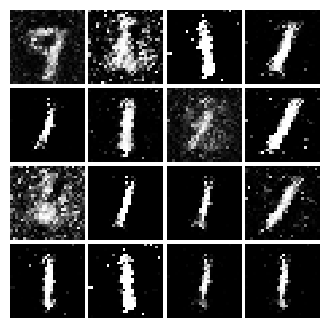


Train Time: 109.18 Epoch:   7 D: 0.3835 G: 2.6361


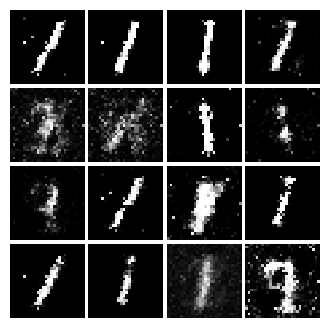


Train Time: 123.04 Epoch:   8 D: 0.3605 G: 2.7057


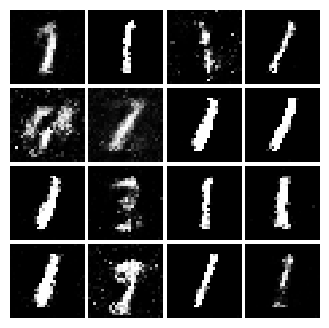


Train Time: 136.89 Epoch:   9 D: 0.4968 G: 2.3492


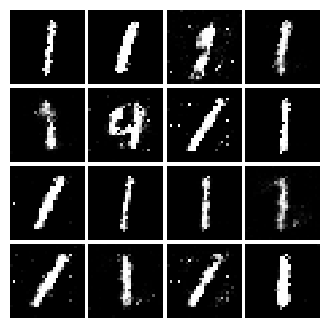


Train Time: 150.46 Epoch:  10 D: 0.4785 G: 2.1527


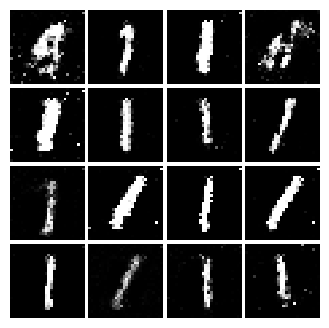


Train Time: 164.25 Epoch:  11 D: 0.3020 G: 1.5740


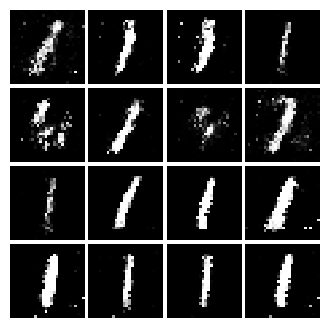


Train Time: 177.75 Epoch:  12 D: 0.4316 G: 2.7398


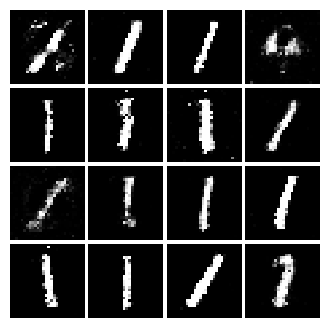


Train Time: 191.20 Epoch:  13 D: 0.4333 G: 2.4393


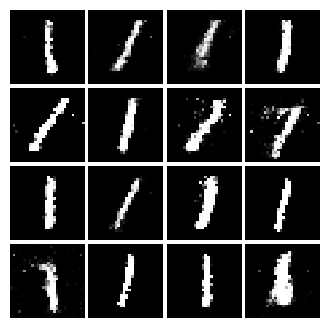


Train Time: 204.88 Epoch:  14 D: 0.4431 G: 1.9312


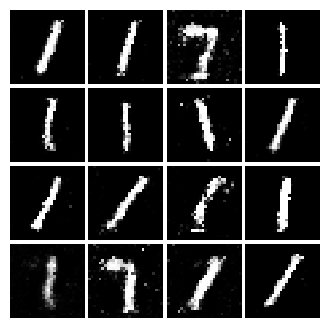


Train Time: 218.42 Epoch:  15 D: 0.3726 G: 2.2945


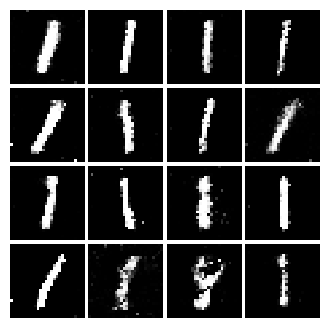


Train Time: 232.34 Epoch:  16 D: 0.3596 G: 3.0721


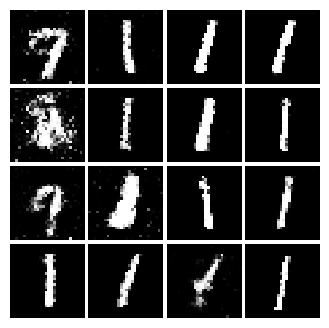


Train Time: 246.04 Epoch:  17 D: 0.3877 G: 2.5178


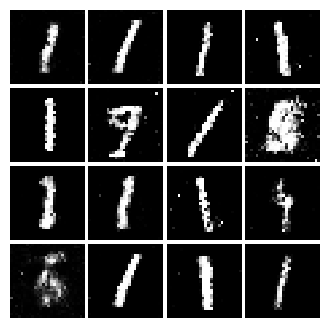


Train Time: 259.72 Epoch:  18 D: 0.4163 G: 2.4987


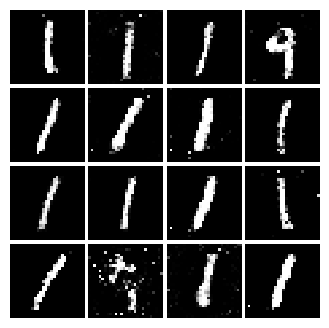


Train Time: 273.47 Epoch:  19 D: 0.4381 G: 2.5245


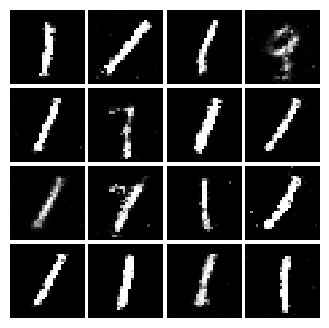


Train Time: 287.17 Epoch:  20 D: 0.3844 G: 2.1780


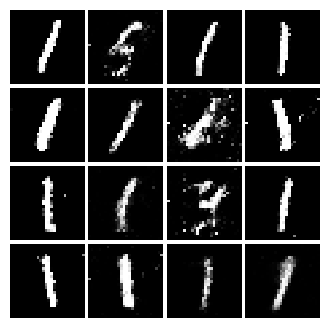


Train Time: 301.10 Epoch:  21 D: 0.4751 G: 2.1052


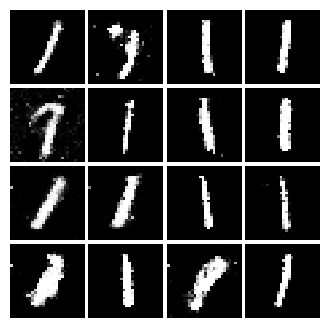


Train Time: 314.67 Epoch:  22 D: 0.4371 G: 1.9711


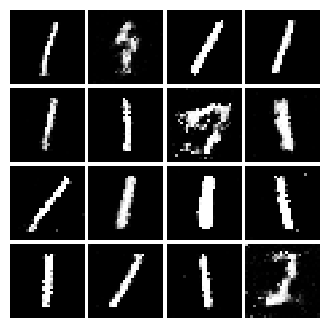


Train Time: 328.26 Epoch:  23 D: 0.5039 G: 2.0611


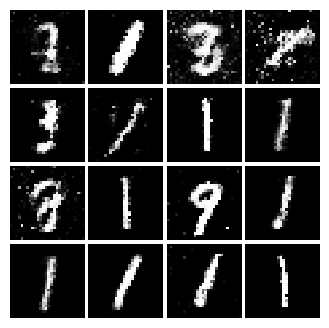


Train Time: 341.97 Epoch:  24 D: 0.4473 G: 2.2431


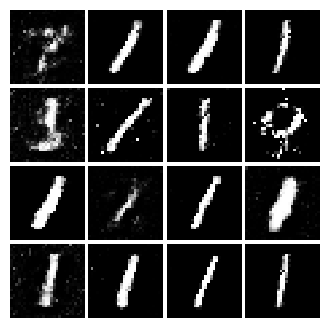


Train Time: 355.40 Epoch:  25 D: 0.6050 G: 2.3918


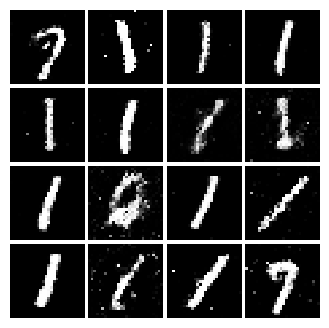


Train Time: 369.46 Epoch:  26 D: 0.4369 G: 2.3351


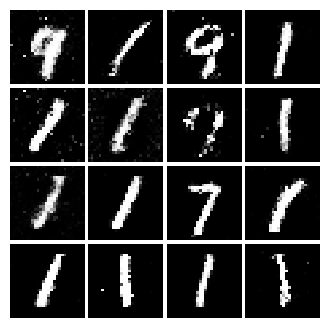


Train Time: 382.82 Epoch:  27 D: 0.7190 G: 1.9716


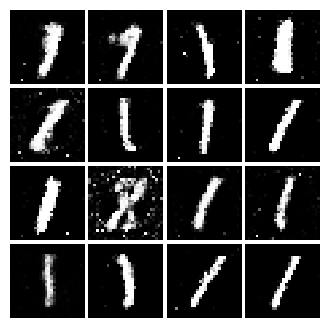


Train Time: 396.40 Epoch:  28 D: 0.4880 G: 2.7110


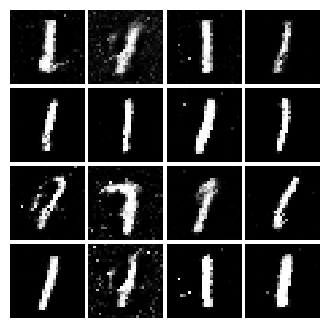


Train Time: 410.26 Epoch:  29 D: 0.4425 G: 1.9572


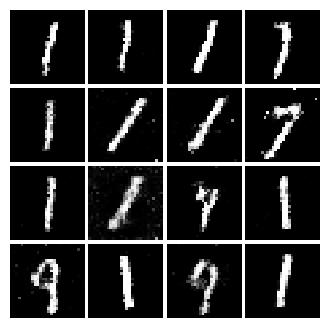

In [ ]:
from gan import discriminator_loss
from gan import generator_loss

reset_seed(0)

input_size = 784
d_hidden_dim = 256
g_hidden_dim = 1024
noise_size = 96

epochs = 30

D = get_discriminator(input_size, d_hidden_dim)
G = get_generator(noise_size, g_hidden_dim, input_size)

D_solver = optim.Adam(D.parameters(), lr=1e-3, betas=[0.5, 0.999])
G_solver = optim.Adam(G.parameters(), lr=1e-3, betas=[0.5, 0.999])

# Run it!
train_gan(train_loader, D, G, D_solver, G_solver, discriminator_loss,
          generator_loss, noise_size, epochs, 'fcgan.jpg',5)

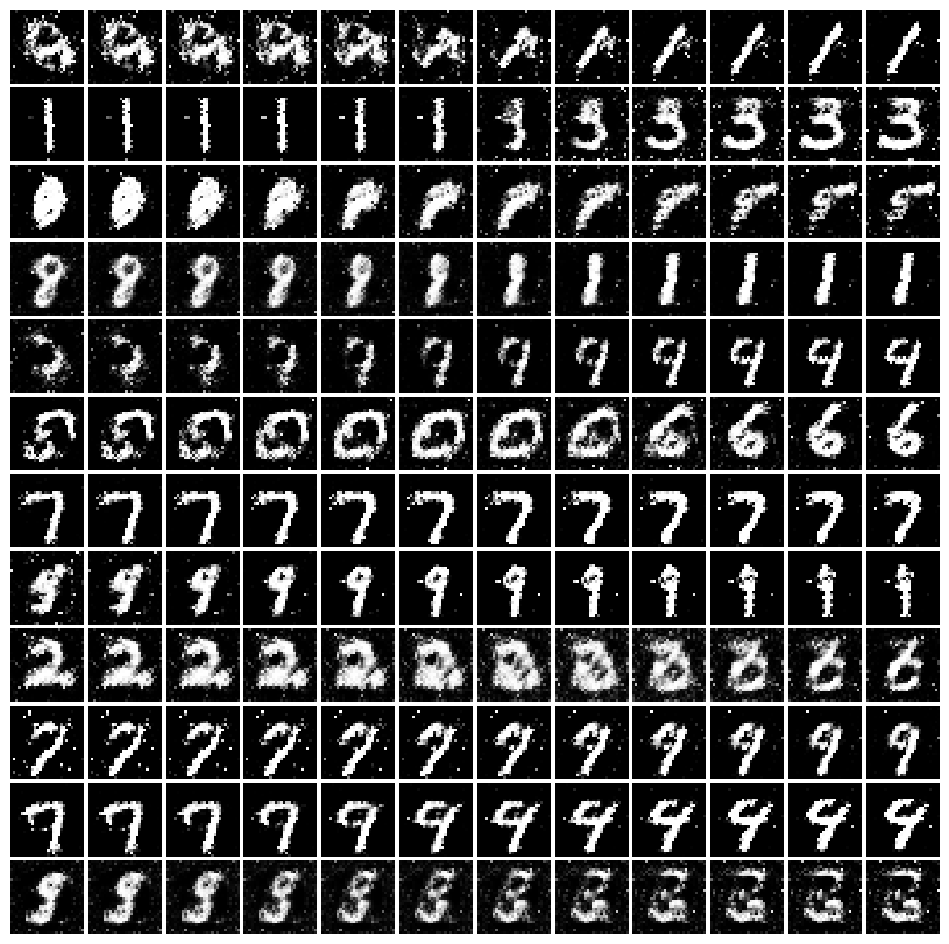

In [ ]:
reset_seed(0)

num_images = 12
num_images_sq = num_images * num_images

z0 = sample_noise(num_images, noise_size)
z1 = sample_noise(num_images, noise_size)
w = torch.linspace(0, 1, num_images).view(num_images, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(num_images_sq, noise_size)
z = z.to(device)

x = G(z).data.cpu().numpy()
show_images(x)

In [ ]:
x.shape

(144, 784)

In [ ]:
z0.shape

torch.Size([12, 96])

In [ ]:
w.shape

torch.Size([12, 1, 1])

In [ ]:
z.shape

torch.Size([144, 96])

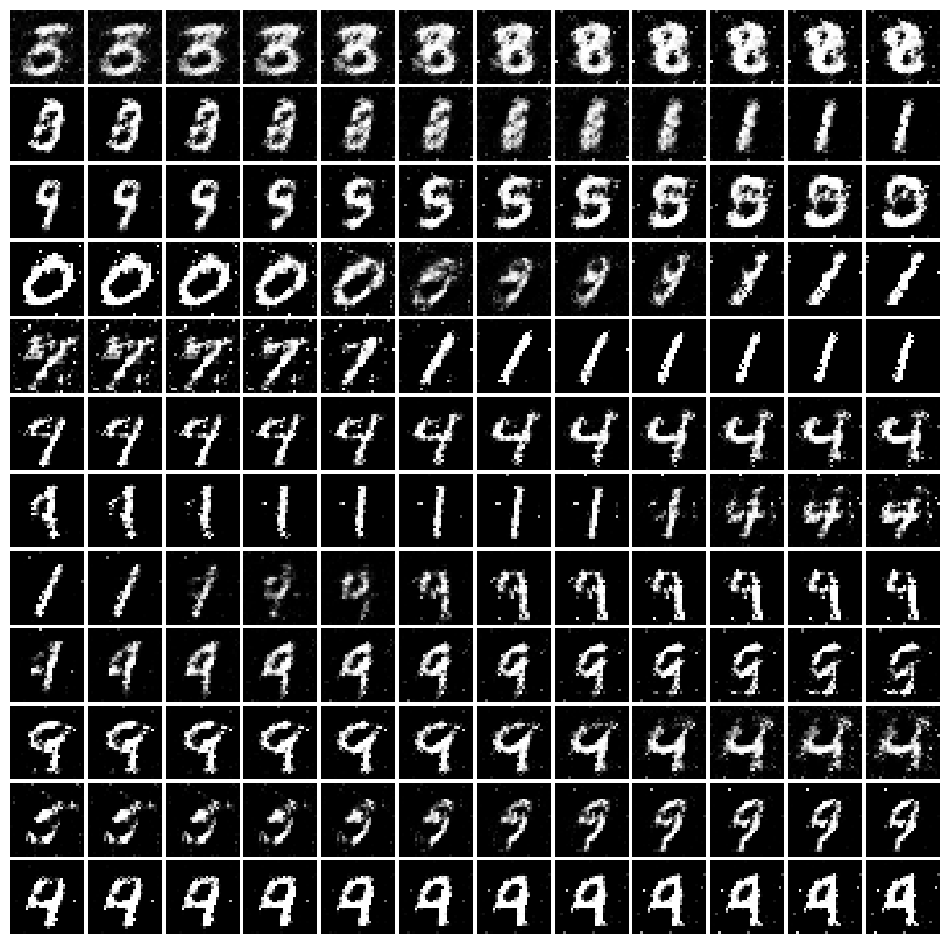

In [ ]:
reset_seed(1)

num_images = 12
num_images_sq = num_images * num_images

z0 = sample_noise(num_images, noise_size)
z1 = sample_noise(num_images, noise_size)
w = torch.linspace(0, 1, num_images).view(num_images, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(num_images_sq, noise_size)
z = z.to(device)


x = G(z).data.cpu().numpy()
show_images(x)

In [ ]:
z0.shape

torch.Size([12, 96])

In [ ]:
x.shape

(12, 784)